In [3]:
#IMPORTS
%run ../datuslib.ipynb

In [4]:
#CARGA DATA

A_tweets = pd.read_csv(generateAbsolutePath("train.csv"))

In [33]:
#CARGA DE INTERNET PALBRAS NEGATIVAS

A_NEGATIVE_WORDS = getWordInListFromFile('negativeWords.txt')

# PLOT: Relacionando negatividad de los tweets y su longitud con si son desastres o no

In [43]:
#MOLDEANDO DATA
A_tweets1 = A_tweets.copy()

#(AGREGA) CAMPO DE TARGET CON NOMBRES MAS DETALLADOS QUE 1 o 0
A_tweets1['Categoria'] = A_tweets1.apply(lambda row : mapBinaryLabel(row['target'],
                                                                            ['Desastre','No Desastre']), axis = 1)
#(AGREGA) CAMPO DE LONGITUD DE TWEETS
A_tweets1['length'] = A_tweets1.apply(lambda row : len(row['text']), axis = 1)

#(AGREGA) CAMPO DE PALABRAS NEGATIVAS
A_tweets1['usa palabras negativas'] = A_tweets1.apply(lambda row : mapBinaryLabel(hasCertainWords(row['text'],A_NEGATIVE_WORDS),['Usa Palabras Negativas','No Usa Palabras Negativas']), axis = 1)


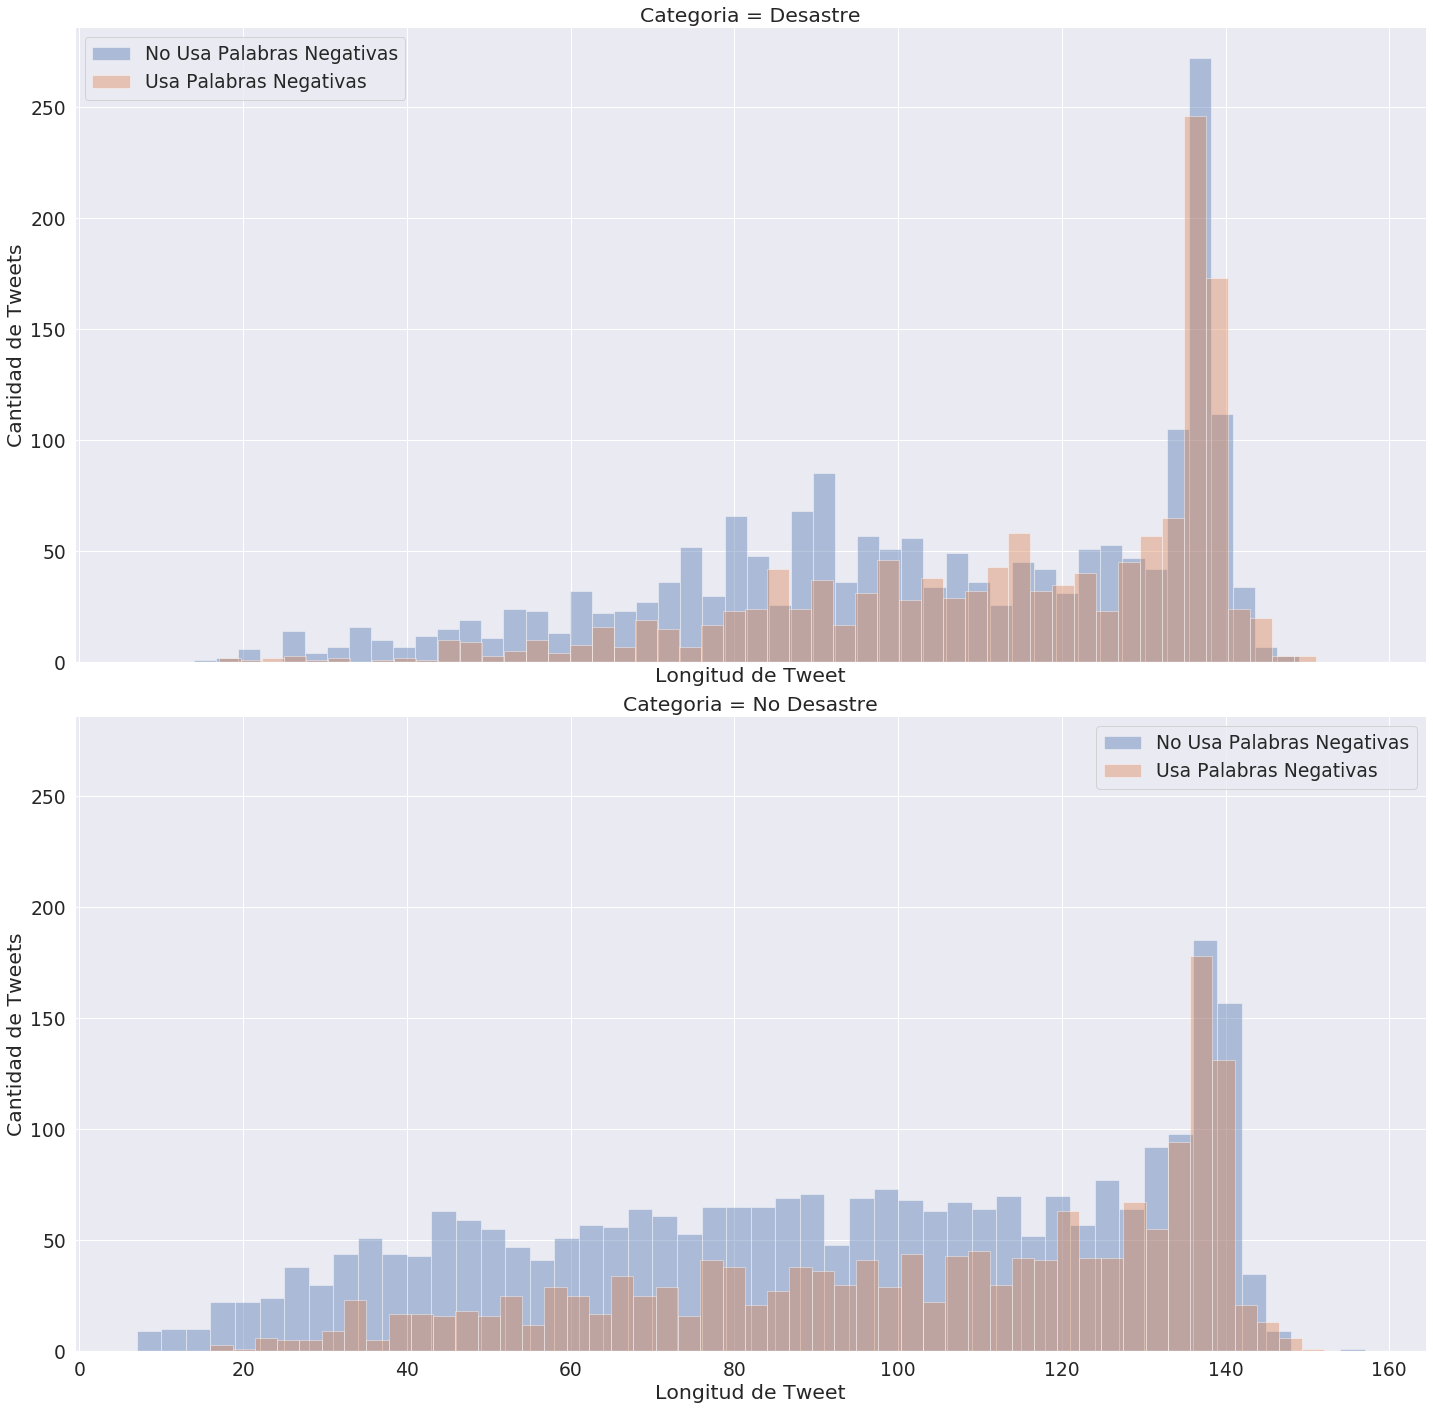

In [38]:
sns.set(font_scale = 1.7)
fg1 = sns.FacetGrid(A_tweets1, hue = 'usa palabras negativas',row = 'Categoria', height = 10, aspect = 2)
v = fg1.map(sns.distplot, "length", kde = False, bins = 50 )


for ax in v.axes.ravel():
    ax.legend()
    ax.set(xlabel = 'Longitud de Tweet', ylabel = 'Cantidad de Tweets')


# Analisis: 

Parece que en el caso de los desastres no parece haber diferencia en los tweets en cuanto a si usa o no palabras negativas (salvo en aquellos de longitud media que parecen tener un pequeña tendencia a ser mas neutros que negativos)

Por otro lado, en el caso de los no desastres, es claro que predominan en cualquier longitud de tweet (salvo en los largos) los tweets neutros

# Conclusion: 

La conclusion es doble:

    Si el tweet no es de longitud media y es neutro, mas probable es que sea no sea un desastre
    
    Si el tweet es no es muy largo y es







# FEATURE: Agregando escala de negatividad de un tweet (0 es nada y 1 es pura)

In [44]:
#MOLDEANDO DATA
A_tweets2 = A_tweets.copy()

#(AGREGA) CAMPO DE NEGATIVIDAD
A_tweets1['negativity'] = A_tweets1.apply(lambda row : getNegativity(row['text'],A_NEGATIVE_WORDS), axis = 1)
